In [2]:
import functions
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from scipy.signal import  filtfilt, butter, iirnotch, savgol_filter
from sklearn.decomposition import FastICA as skFastICA
from hosd_python.hosd import apply_hosd # library that I converted from MATLAB

In [2]:
no_ica_chans = 18
fs=1000
span = 10*fs
offset = 100*fs 
ms2s = lambda x, _:f'{x/1000:g}' 

In [3]:
def bandpass_filter(dd, order=5):
    b, a = butter(order, [2, 99], btype='band', fs=1000)
    b_notch, a_notch = iirnotch(50, 40, fs=1000)
    data = deepcopy(dd)
    for i in range(1,data.shape[1]):
        data[:,i] = filtfilt(b, a, data[:,i])
        data[:,i] = filtfilt(b_notch, a_notch, data[:,i])
    return data

In [4]:
dd = functions.array_from_TDMSgroup("patients/P044/P044_S01_D2024-04-18_G36.tdms", "R001")
filtered_data = bandpass_filter(dd)

In [5]:
ica = skFastICA(n_components=no_ica_chans,algorithm='deflation',max_iter=4000,fun='logcosh',tol=1e-5)
S_ = ica.fit_transform(filtered_data[5000:,1:])
A_ = ica.mixing_

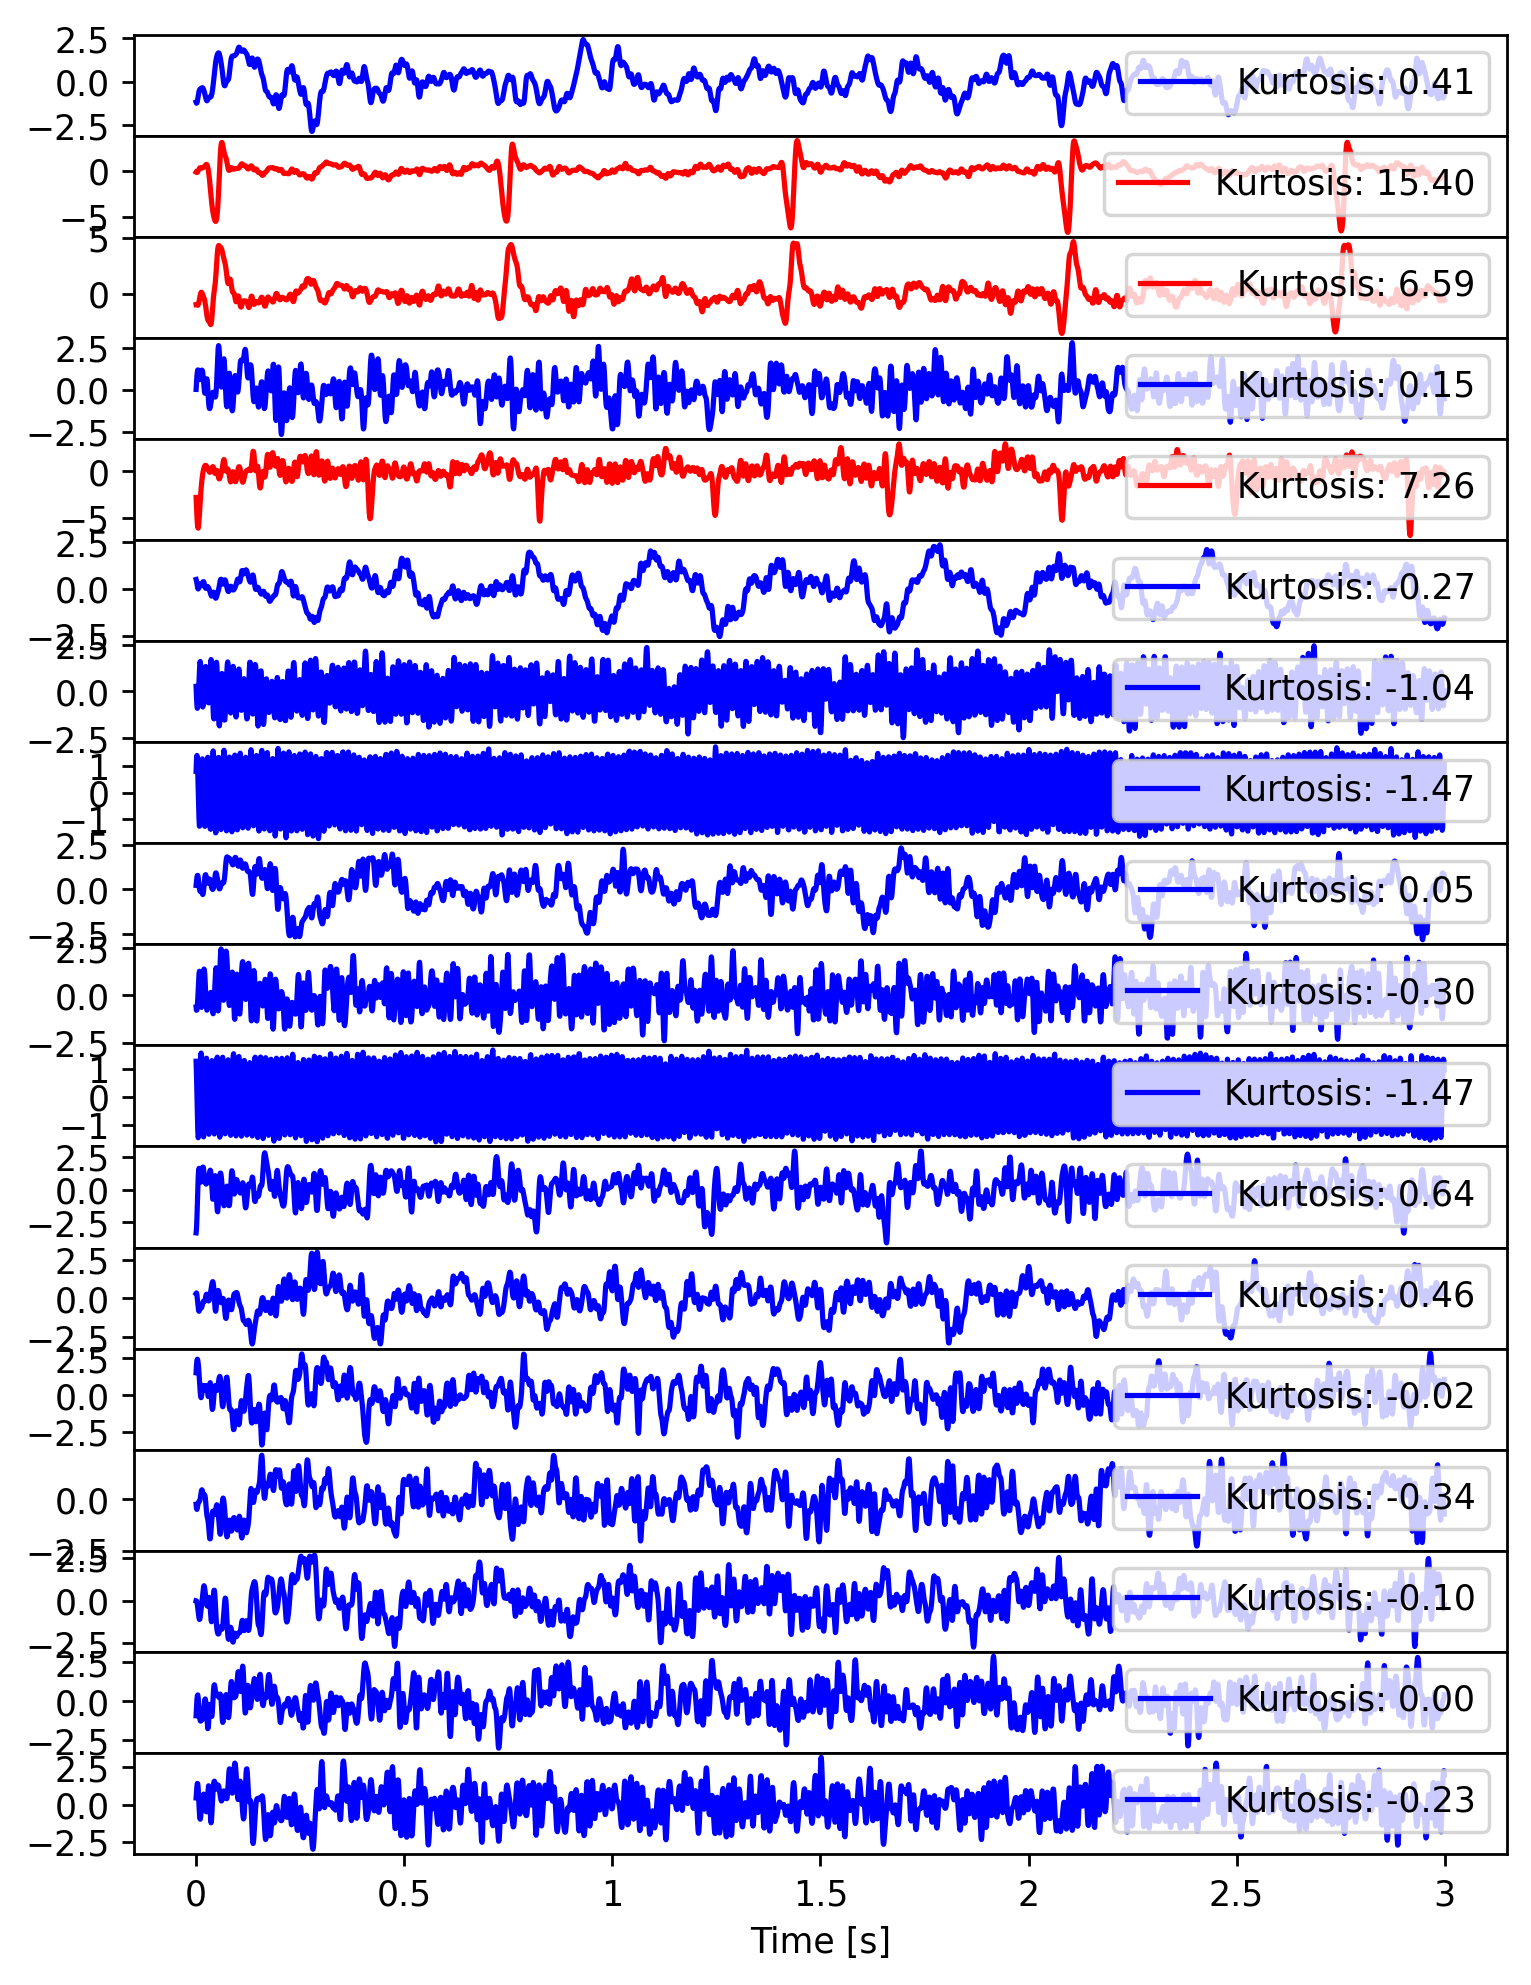

In [24]:
no_ica_chans = S_.shape[1]
fs = 1000
span = 3000
offset = 100 * fs 
ms2s = lambda x, _: f'{x / 1000:g}' 

kurtosis_values = [stats.kurtosis(S_[offset:(offset + span), j]) for j in range(no_ica_chans)]

# Plot
fig, ax = plt.subplots(no_ica_chans, 1, sharex=True, figsize=(18 / 2.54, 24 / 2.54), dpi=250)
fig.subplots_adjust(hspace=0)

for j in range(no_ica_chans):
    ax[j].plot(S_[offset:(offset + span), j], label=f'Kurtosis: {kurtosis_values[j]:.2f}', color='red' if kurtosis_values[j] > 1.8 else 'blue')
    ax[j].legend(loc=1)
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')
plt.show()


In [25]:
threshold = 1.8

# Indices of components with kurtosis above threshold
selected_indices = [i for i, k in enumerate(kurtosis_values) if k > threshold]
B = np.zeros_like(A_)
B[:, selected_indices] = A_[:, selected_indices]
recon = np.dot(S_, B.T)


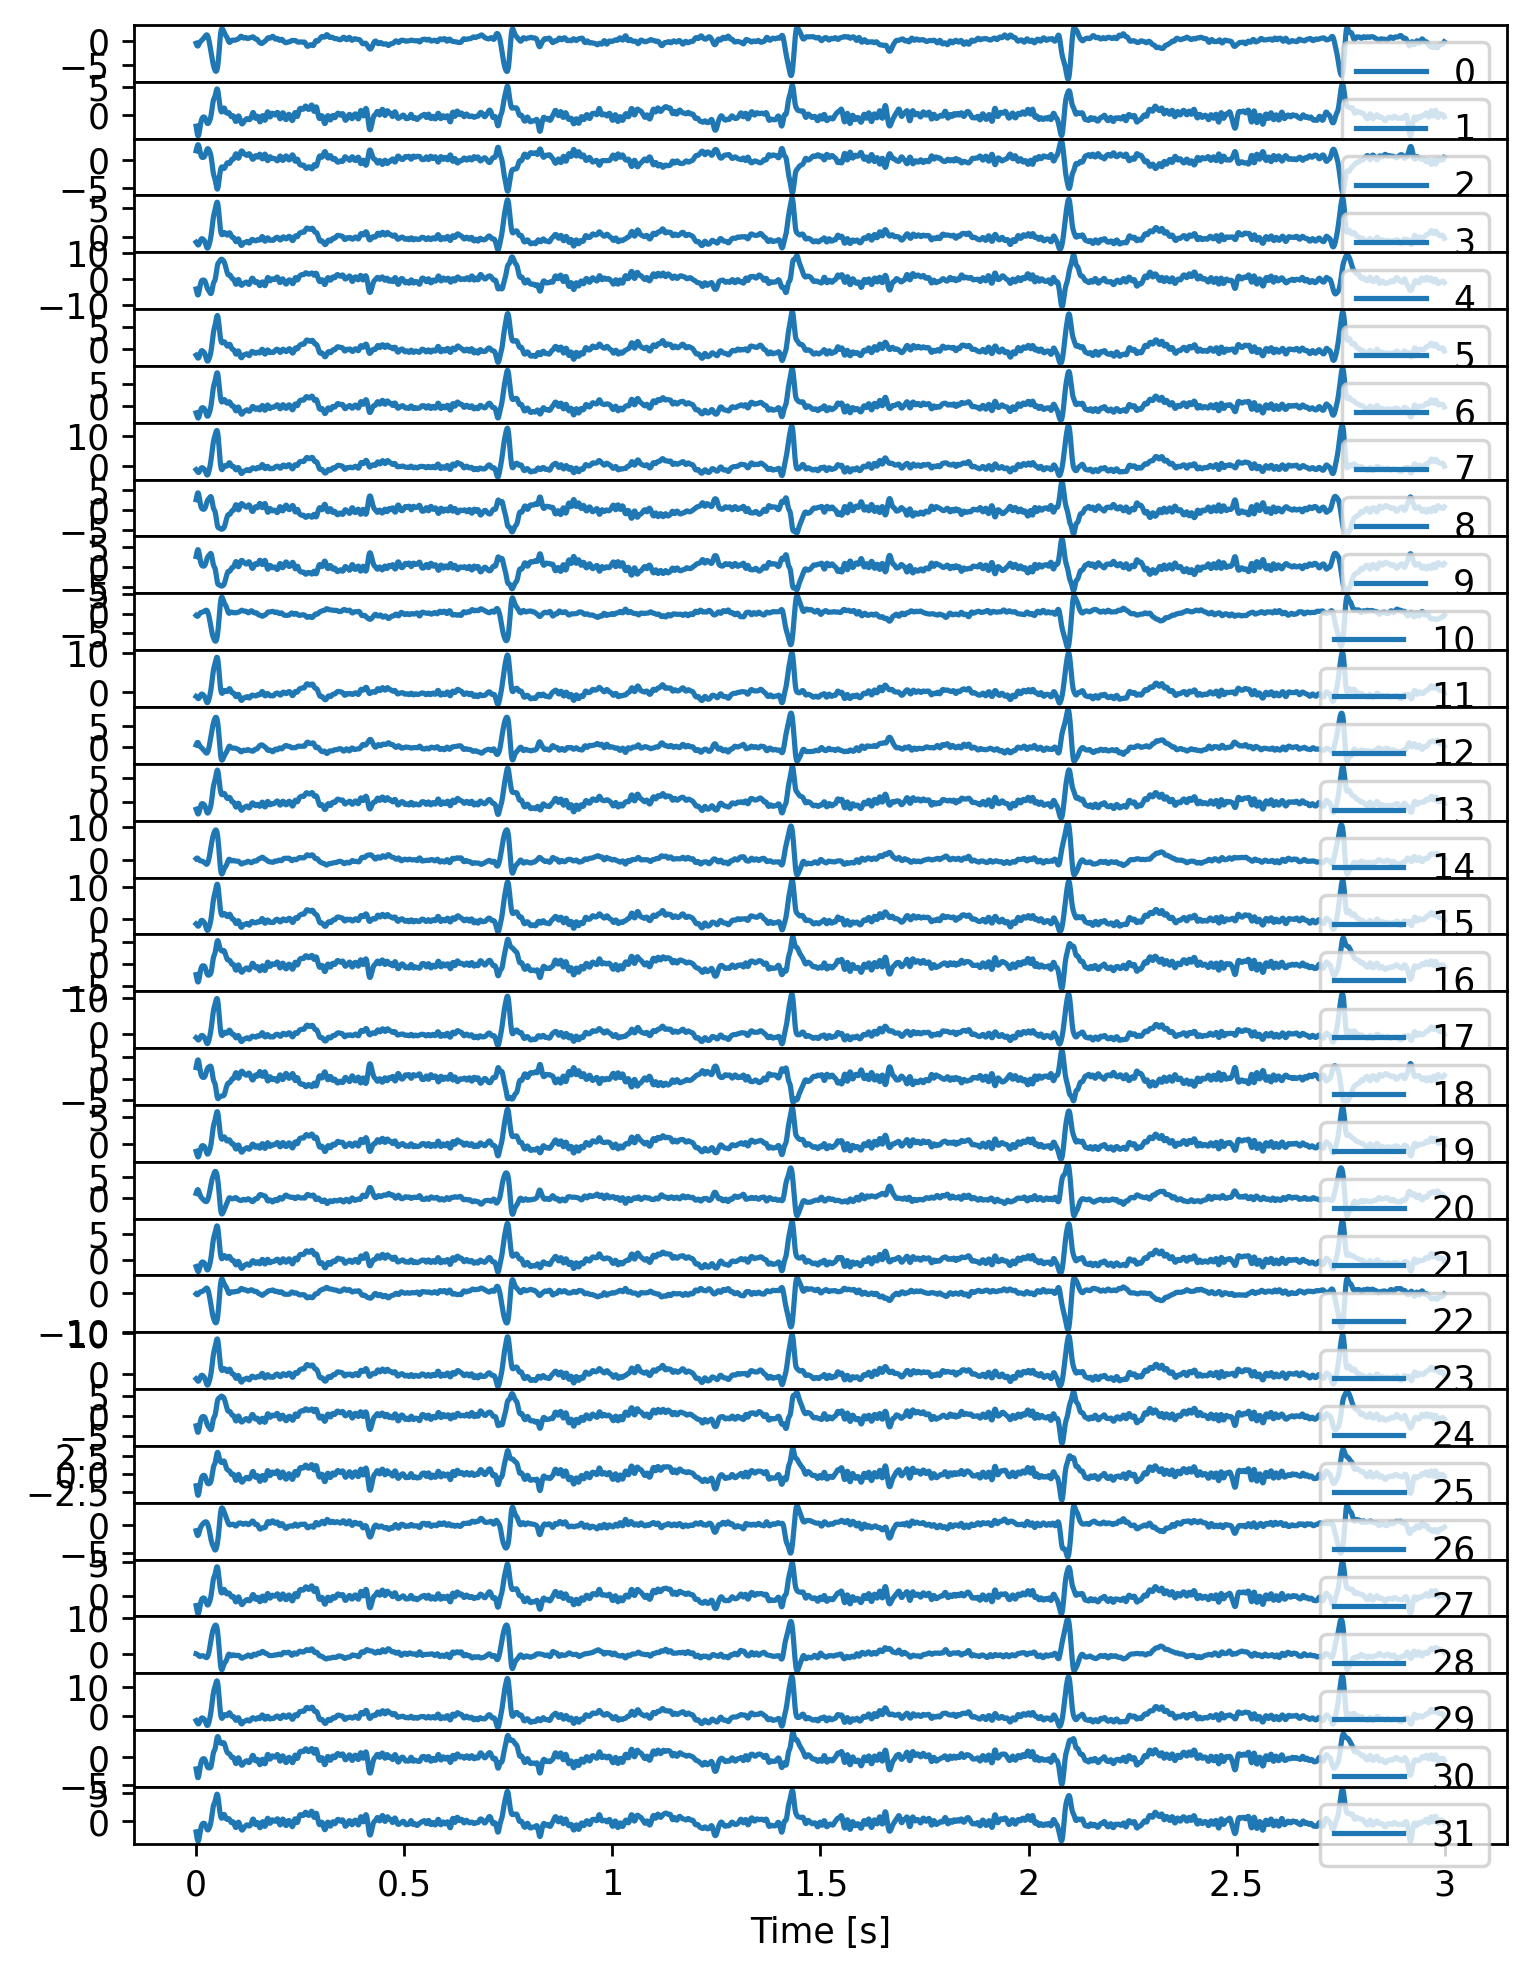

In [26]:
ç

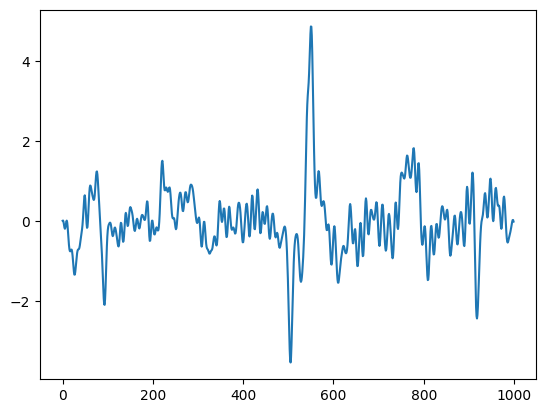

In [27]:
plt.plot(recon[offset-500:(offset + 500), 31])

In [28]:
indices = [i for i in selected_indices if i not in (4,)]

B2 = np.zeros_like(A_)
B2[:, indices] = A_[:, indices]
recon2 = np.dot(S_, B2.T)

In [29]:
print(indices)

[1, 2]


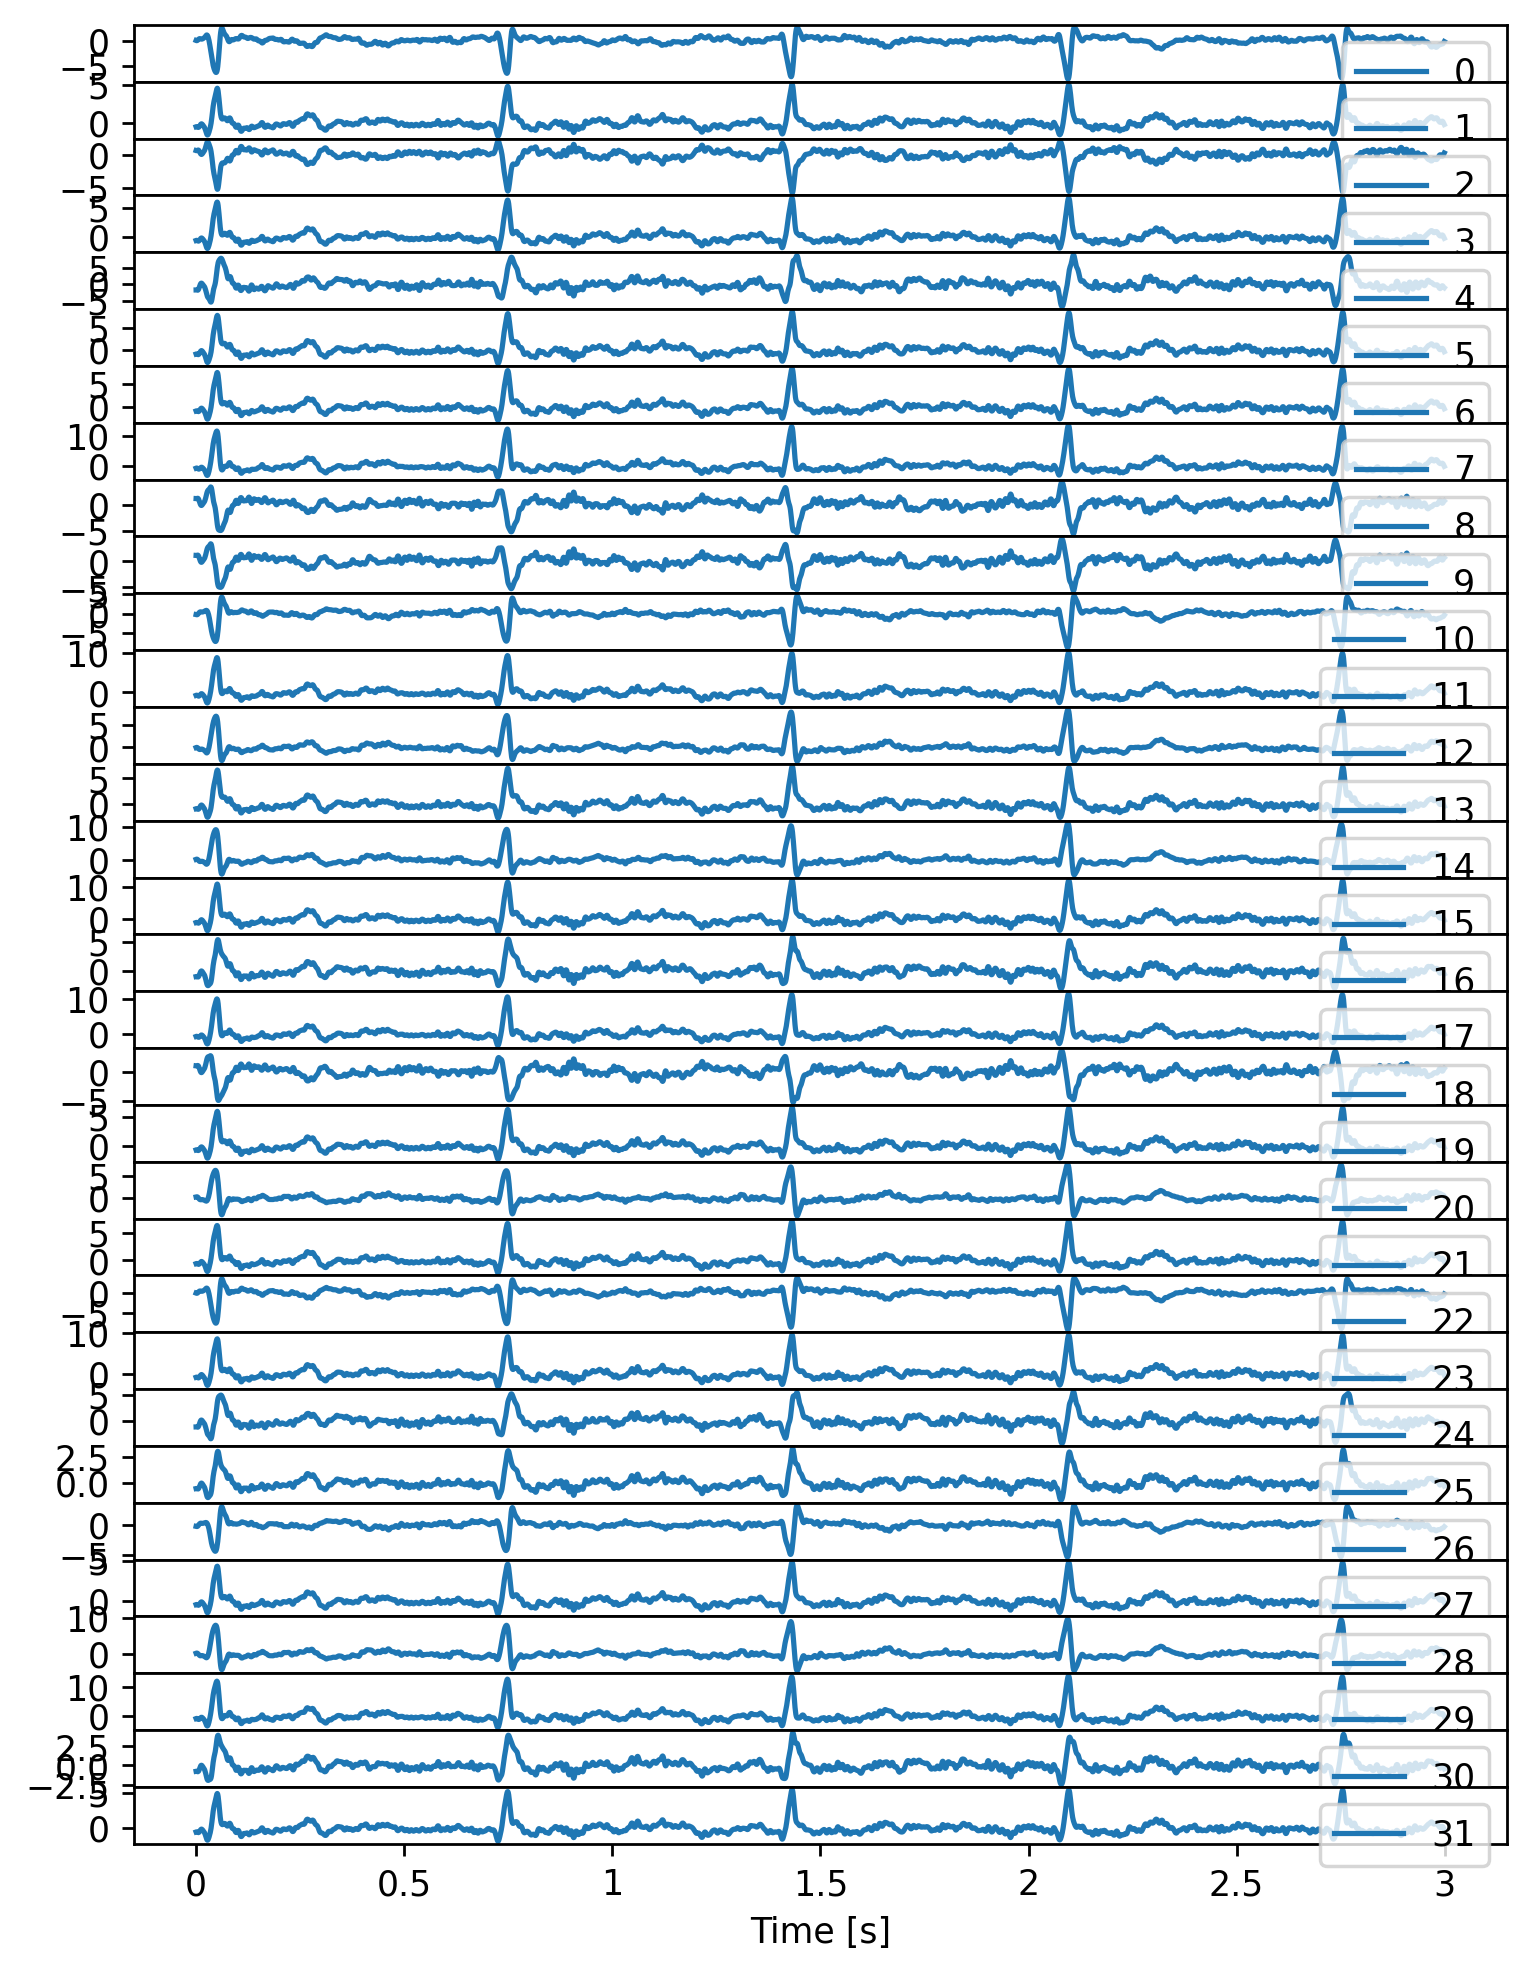

In [30]:
fig, ax = plt.subplots(recon2.shape[1], 1, sharex=True, figsize=(18 / 2.54, 24 / 2.54), dpi=250)
fig.subplots_adjust(hspace=0)

for j in range(recon2.shape[1]):
    ax[j].plot(recon2[offset:(offset + span), j], label=str(j))
    ax[j].legend(loc=1)
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')
plt.show()

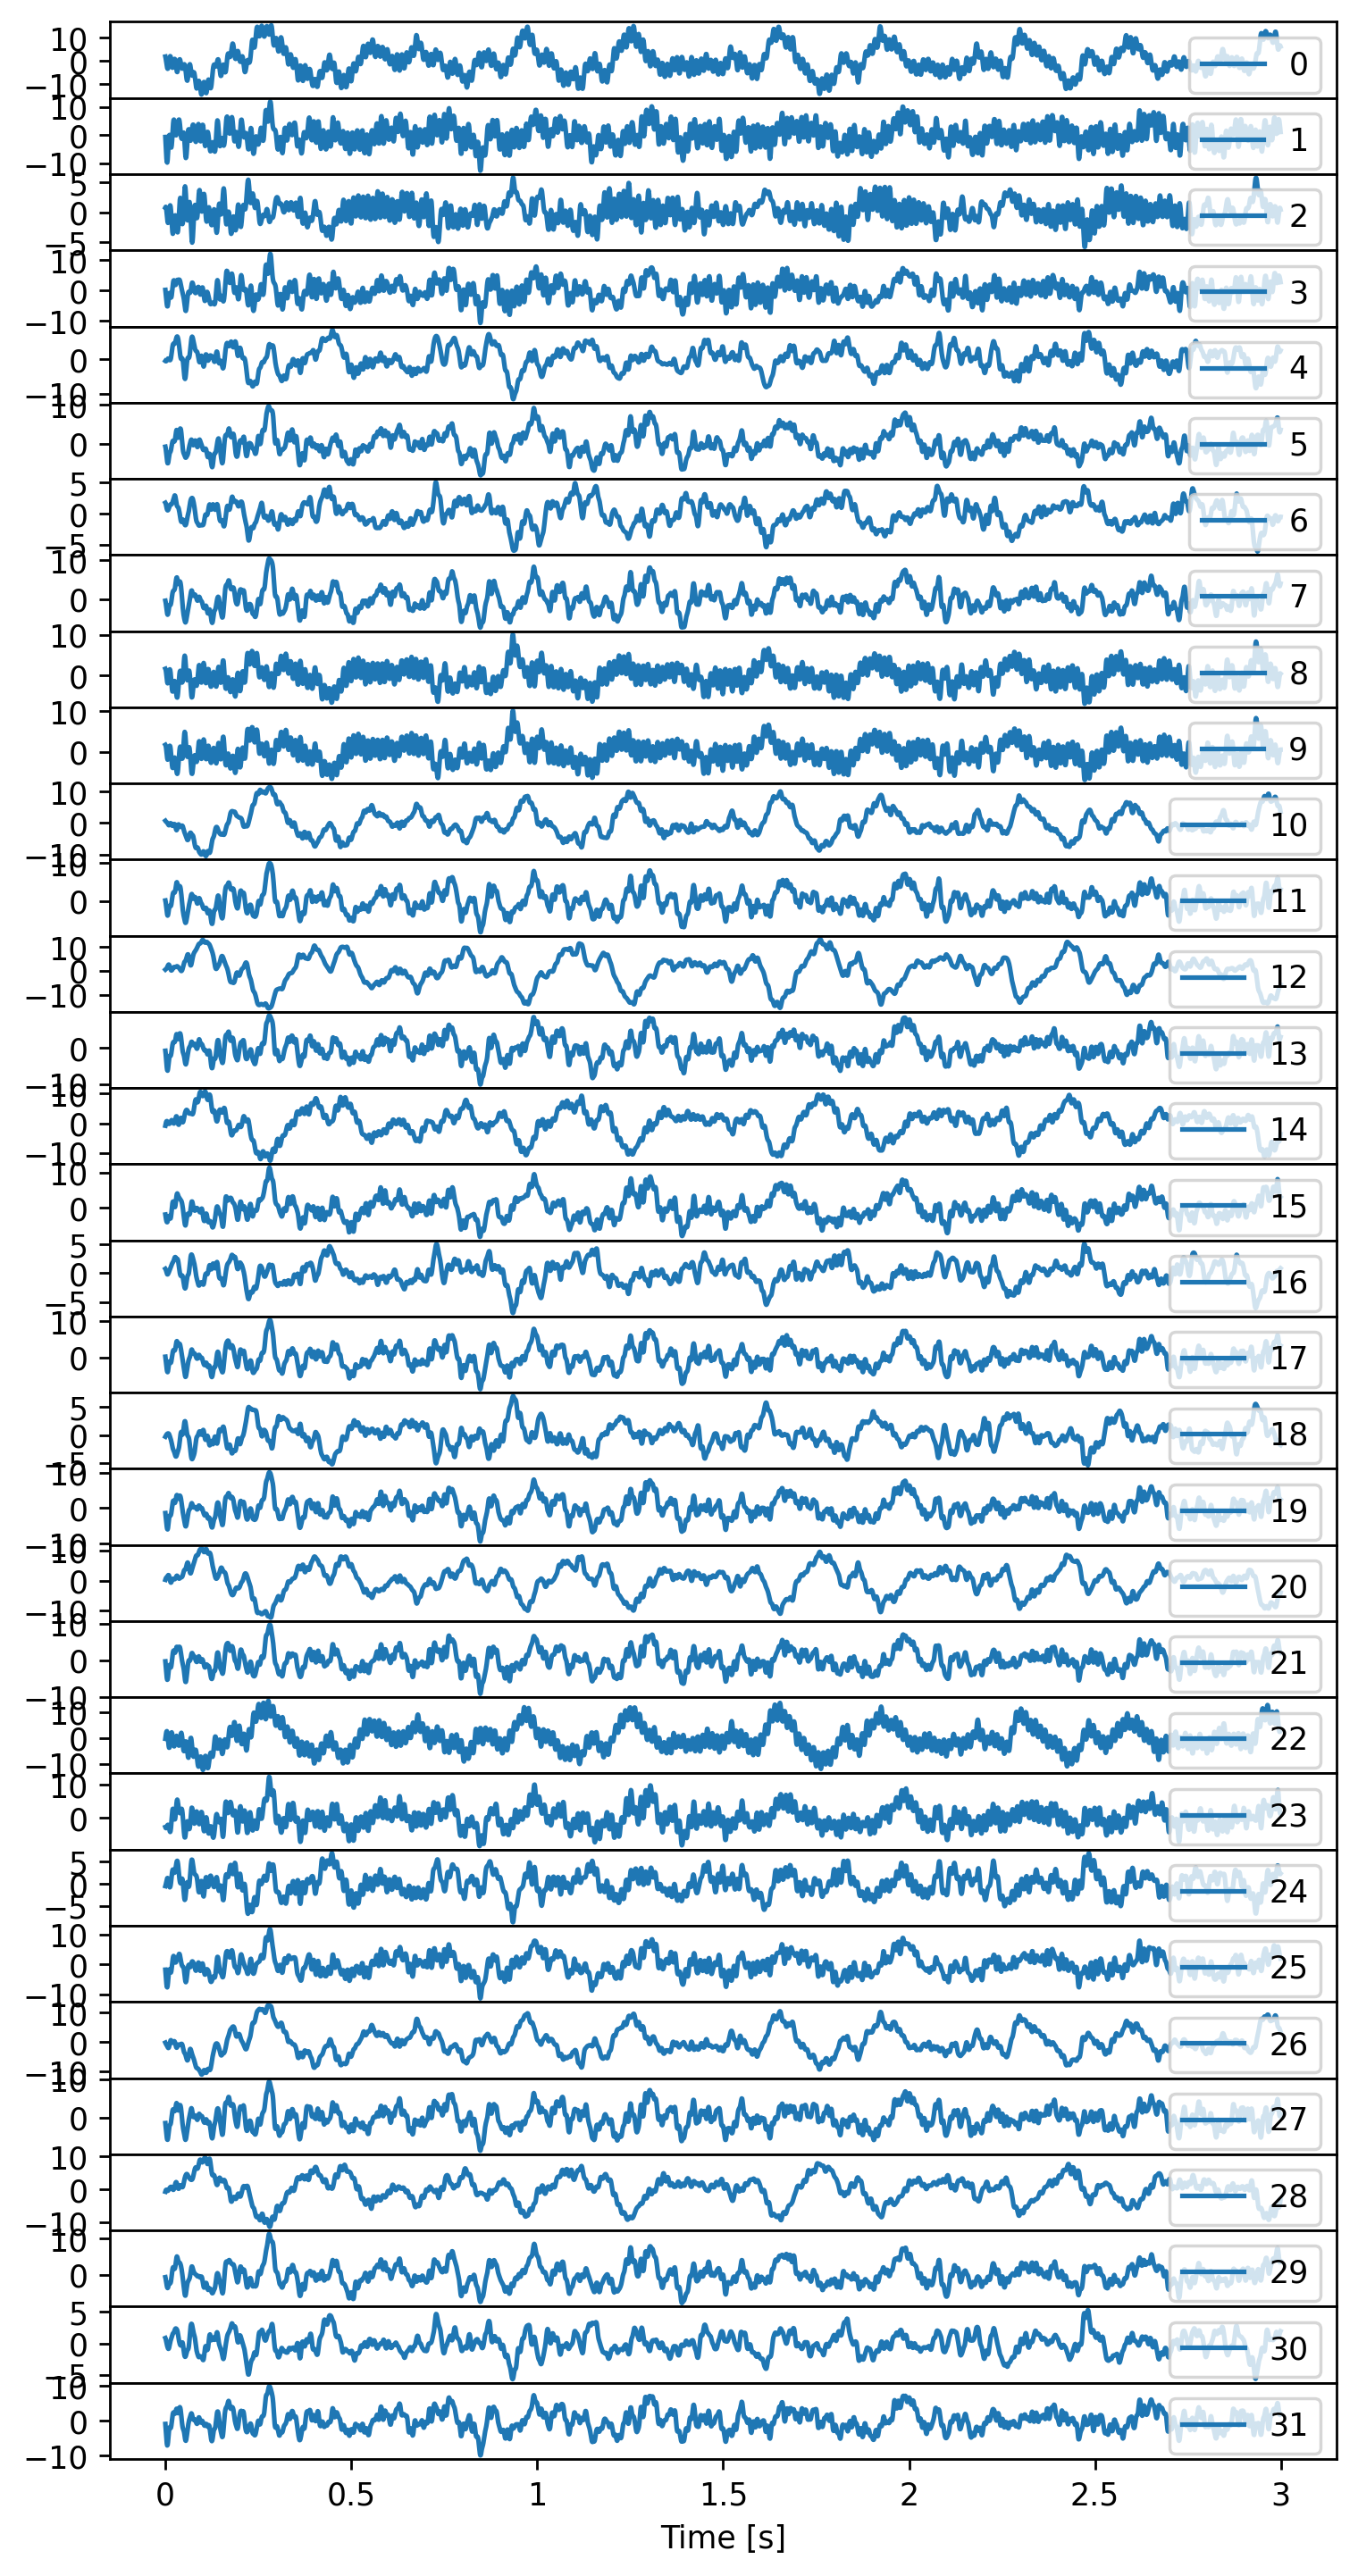

In [33]:
fetals = filtered_data[5000:,1:] - recon2

fig, ax = plt.subplots(fetals.shape[1], 1, sharex=True, figsize=(18 / 2.54, 36 / 2.54), dpi=250)
fig.subplots_adjust(hspace=0)

for j in range(fetals.shape[1]):
    ax[j].plot(fetals[offset:(offset + span), j], label=str(j))
    ax[j].legend(loc=1)
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')
plt.show()

In [3]:
beat, detect = apply_hosd(fetals[:,0], 1400) 
plt.plot(beat)

NameError: name 'fetals' is not defined